<a href="https://colab.research.google.com/github/VindhyaSRajan/NLP-Projects/blob/master/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports Section

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [10]:
%pwd

'/content'

##Reading the file

In [0]:
!unzip '/content/data.zip'

In [12]:
def findFiles(path): return glob.glob(path)

print(findFiles('/content/data/names/*.txt'))



all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['/content/data/names/Dutch.txt', '/content/data/names/Portuguese.txt', '/content/data/names/English.txt', '/content/data/names/Polish.txt', '/content/data/names/Korean.txt', '/content/data/names/Spanish.txt', '/content/data/names/Greek.txt', '/content/data/names/Scottish.txt', '/content/data/names/French.txt', '/content/data/names/Russian.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Arabic.txt', '/content/data/names/German.txt', '/content/data/names/Czech.txt', '/content/data/names/Japanese.txt', '/content/data/names/Irish.txt', '/content/data/names/Chinese.txt', '/content/data/names/Italian.txt']


In [13]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [0]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [15]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


##Implementing the Pytorch module

In [16]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


##Defining the model

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)




In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
#To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).


In [19]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
#For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9009, -2.9183, -2.9800, -2.8099, -2.8569, -2.8591, -2.9697, -2.8162,
         -2.8395, -2.9457, -2.8619, -2.9377, -2.8123, -2.8699, -2.9192, -2.9819,
         -2.8656, -2.9091]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9009, -2.9183, -2.9800, -2.8099, -2.8569, -2.8591, -2.9697, -2.8162,
         -2.8395, -2.9457, -2.8619, -2.9377, -2.8123, -2.8699, -2.9192, -2.9819,
         -2.8656, -2.9091]], grad_fn=<LogSoftmaxBackward>)


In [20]:
#use Tensor.topk to get the index of the greatest value:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 3)


In [21]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Meadhra
category = Italian / line = Coiro
category = Japanese / line = Abe
category = Spanish / line = Hierro
category = Japanese / line = Saionji
category = German / line = Tillens
category = Russian / line = Markholenko
category = Vietnamese / line = Ha
category = Scottish / line = Gordon
category = Czech / line = Janca


##Loss Function

In [0]:
#Implementing the Loss Function. Since the last layer is a softmax
criterion = nn.NLLLoss()

##Begin Training
Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
* Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss



In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 1.0069 Vedenyapin / Russian ✓
10000 10% (0m 13s) 1.2785 Exley / English ✓
15000 15% (0m 19s) 1.2485 Bokhoven / Dutch ✓
20000 20% (0m 26s) 1.3930 Pasternak / Polish ✓
25000 25% (0m 33s) 0.2573 Gwozdek / Polish ✓
30000 30% (0m 39s) 1.0536 Bleier / German ✓
35000 35% (0m 46s) 1.5016 Scolaidhe / Irish ✓
40000 40% (0m 52s) 3.2710 Gwock / Korean ✗ (Chinese)
45000 45% (0m 59s) 1.7032 Shum / Korean ✗ (Chinese)
50000 50% (1m 6s) 0.2060 Vu / Vietnamese ✓
55000 55% (1m 13s) 3.1214 Dolejsi / Italian ✗ (Czech)
60000 60% (1m 19s) 0.3419 Ko / Korean ✓
65000 65% (1m 26s) 1.5533 Tzel'Ko / Japanese ✗ (Russian)
70000 70% (1m 32s) 1.6498 Stewart / English ✗ (Scottish)
75000 75% (1m 39s) 0.1284 Ferguson / Scottish ✓
80000 80% (1m 46s) 0.6654 Veverka / Czech ✓
85000 85% (1m 52s) 0.6590 Beringer / French ✓
90000 90% (1m 59s) 0.1744 Xydis / Greek ✓
95000 95% (2m 6s) 1.3141 Sokolofsky / Russian ✗ (Polish)
100000 100% (2m 13s) 2.2307 Terrazas / Greek ✗ (Spanish)


##Plot of the results

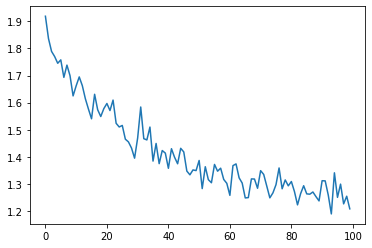

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

##Results Evaluation

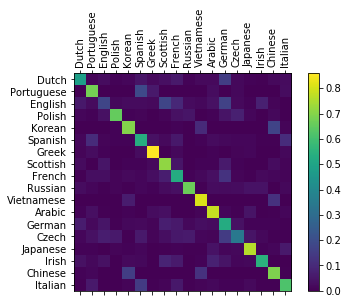

In [30]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

##Try the model on test set (Here, User Input)

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Brian')
predict('Ahmed')
predict('Salman')


> Brian
(-1.02) Scottish
(-1.81) Vietnamese
(-2.17) Irish

> Ahmed
(-0.38) Arabic
(-2.10) German
(-2.95) French

> Salman
(-0.96) Irish
(-2.13) French
(-2.21) Arabic
